[Get the data](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html)

In [ ]:
from google.colab import drive
import sys, os
import warnings 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
sys.path.append('/content/drive/Shareddrives/ECE219_P2')
import plotmat

In [ ]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import numpy as np
import random
np.random.seed(42)
random.seed(42)

In [ ]:
newsgroups_train = fetch_20newsgroups(subset = 'train')

In [ ]:
from pprint import pprint
pprint(list(newsgroups_train.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [ ]:
print(newsgroups_train.filenames.shape)
print(newsgroups_train.target.shape)

(11314,)
(11314,)


Clustering task: 

* Class 1: comp.graphics, comp.os.ms-windows.misc, comp.sys.ibm.pc.hardware, comp.sys.mac.hardware
* class 2: rec.autos, rec.motorcycles, rec.sports.baseball, rec.sport.hockey




In [ ]:
class1 = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
class2 = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
all_groups = class1 + class2

#Part1

## Question 1

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


Remove the headers and footers when extract dataset

In [ ]:
newsgroups_train = fetch_20newsgroups(subset='all', categories = all_groups, 
                                      shuffle = True, random_state = 42, 
                                      remove = ('headers', 'footers'))

In [ ]:
newsgroups_train.target.shape

(7882,)

In [ ]:
tfidf_vect = TfidfVectorizer(stop_words='english', min_df=3)
X_train_tfidf = tfidf_vect.fit_transform(newsgroups_train.data)

In [ ]:
print("The dimensions of the TF-IDF matrix:", X_train_tfidf.shape)

The dimensions of the TF-IDF matrix: (7882, 23522)


## Question 2


[K-means clustering](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix

In [ ]:
np.info(newsgroups_train.target)

class:  ndarray
shape:  (7882,)
strides:  (8,)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0xc41ff60
byteorder:  little
byteswap:  False
type: int64


In [ ]:
np.min(newsgroups_train.target)

0

In [ ]:
np.max(newsgroups_train.target)

7

We only want 2 classes, which means that we need to reassign the target (y).

*   the groups in Class 1 were corresponding to 0, 1, 2, 3. (-> 0)
*   the groups in Class 2 were corresponding to 4, 5, 6, 7. (-> 1)



In [ ]:
y_target = []
for i in newsgroups_train.target:
  y_target.append(i//4)
y_target = np.array(y_target)

In [ ]:
kmeans = KMeans(
    n_clusters=2,
    random_state=0,
    max_iter=1500,
    n_init=30,
)
y_pred = kmeans.fit_predict(X_train_tfidf)
con_matrix = contingency_matrix(y_target, y_pred)

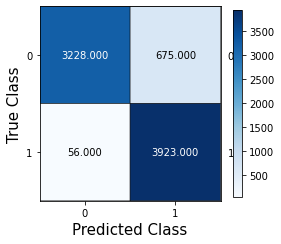

In [ ]:
plotmat.plot_mat(con_matrix, size=(4,3.5), if_show_values = True, colorbar = True, 
                 xlabel = "Predicted Class", ylabel = "True Class", grid = 'k')

The contingency matrix is as follows:

In [ ]:
con_matrix

array([[3228,  675],
       [  56, 3923]])

## Question 3

In [ ]:
from collections import defaultdict
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn import metrics
from time import time

evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    # train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        # t0 = time()
        km.fit(X)
        # train_times.append(time() - t0)
        # change labels to y_target to ensure it represents the dataset.target!
        scores["Homogeneity"].append(metrics.homogeneity_score(y_target, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(y_target, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(y_target, km.labels_))
        scores["Adjusted Rand-Index"].append(metrics.adjusted_rand_score(y_target, km.labels_))
        scores["Adjusted mutual information score"].append(adjusted_mutual_info_score(y_target, km.labels_))
    # train_times = np.asarray(train_times)

    # print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        # "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        # "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

In [ ]:
print("Homogeneity score: ", metrics.homogeneity_score(y_target,y_pred))
print("Completeness score: ",metrics.completeness_score(y_target,y_pred))
print("V-measure score: ",metrics.v_measure_score(y_target,y_pred))
print("Adjusted Rand score: ",metrics.adjusted_rand_score(y_target,y_pred))
print("Adjusted mutual information score: ",metrics.adjusted_mutual_info_score(y_target,y_pred))

Homogeneity score:  0.5970261185675823
Completeness score:  0.6092574424628718
V-measure score:  0.6030797696874812
Adjusted Rand score:  0.6633908006015733
Adjusted mutual information score:  0.6030430627722567


In [ ]:
fit_and_evaluate(kmeans, X_train_tfidf, name="KMeans\non tf-idf vectors")

Homogeneity: 0.582 ± 0.012
Completeness: 0.596 ± 0.011
V-measure: 0.589 ± 0.012
Adjusted Rand-Index: 0.644 ± 0.015
Adjusted mutual information score: 0.589 ± 0.012


[Performance Matrices in Clustering](https://towardsdatascience.com/performance-metrics-in-machine-learning-part-3-clustering-d69550662dc6): Adjusted Rand-Index, Adjusted mutual information score.



## Question 4

In [ ]:
from sklearn.decomposition import TruncatedSVD
import plotly.express as px

In [ ]:
svd = TruncatedSVD(n_components=1000, n_iter=7, random_state=42)
svd.fit(X_train_tfidf)

TruncatedSVD(n_components=1000, n_iter=7, random_state=42)

In [ ]:
var_sum = sum(svd.explained_variance_ratio_)
var_percentage = []
r = [i for i in range(1,1001)]
for var in svd.explained_variance_ratio_:
  var_percentage.append(var/var_sum)

In [ ]:
df = pd.DataFrame({'r':r, 'Percentage of Variance':var_percentage})
px.line(df, x='r', y='Percentage of Variance')

Text(0, 0.5, 'Cumulative Expected Variance Ratio')

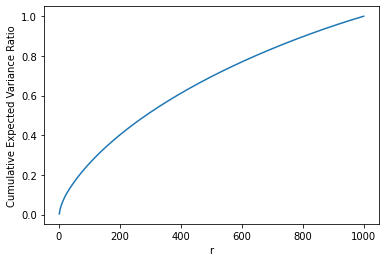

In [ ]:
import matplotlib.pyplot as plt
cum_sum_exp_var_ratio = np.cumsum(var_percentage)
plt.plot(range(1,1001), cum_sum_exp_var_ratio)
plt.xlabel("r")
plt.ylabel("Cumulative Expected Variance Ratio")  

## Question 5

In [ ]:
def fit_and_evaluate2(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name
    evaluations = []

    # train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        km.fit(X)
        scores["Homogeneity"].append(metrics.homogeneity_score(y_target, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(y_target, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(y_target, km.labels_))
        scores["Adjusted Rand-Index"].append(metrics.adjusted_rand_score(y_target, km.labels_))
        scores["Adjusted mutual information score"].append(adjusted_mutual_info_score(y_target, km.labels_))
  
    evaluation = {
        "estimator": name,
    }
    
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        evaluation[score_name] = mean_score
    evaluations.append(evaluation)

    for i in evaluations:
      Homogeneity.append(i['Homogeneity'])
      Completeness.append(i['Completeness'])
      V_measure.append(i['V-measure'])
      Adjusted_Rand_Index.append(i['Adjusted Rand-Index'])
      Adjusted_mutual_information_score.append(i['Adjusted mutual information score'])


In [ ]:
Homogeneity = []
Completeness = []
V_measure = []
Adjusted_Rand_Index = []
Adjusted_mutual_information_score = []

def fit_plot_svd(r):
  for i in r:
    svd = TruncatedSVD(n_components=i, n_iter=7, random_state=42)
    X = svd.fit_transform(X_train_tfidf)
    fit_and_evaluate2(kmeans, X, name=None, n_runs=5)

  homo = pd.DataFrame({'r':r, 'Homogeneity':Homogeneity})
  fig1 = px.line(homo, x='r', y='Homogeneity', title = "Homogeneity", markers=True)
  fig1.show()

  comp = pd.DataFrame({'r':r, 'Completeness':Completeness})
  fig2 = px.line(comp, x='r', y='Completeness', title = "Completeness", markers=True)
  fig2.show()

  v_measure = pd.DataFrame({'r':r, 'v_measure':V_measure})
  fig3 = px.line(v_measure, x='r', y='v_measure', title = "V-measure", markers=True)
  fig3.show()

  rand_index = pd.DataFrame({'r':r, 'Adjusted_Rand_Index':Adjusted_Rand_Index})
  fig4 = px.line(rand_index, x='r', y='Adjusted_Rand_Index', title = "Adjusted Rand Index", markers=True)
  fig4.show()

  ami = pd.DataFrame({'r':r, 'Adjusted_mutual_information_score':Adjusted_mutual_information_score})
  fig5 = px.line(ami, x='r', y='Adjusted_mutual_information_score', title = "Adjusted mutual information score", markers=True)
  fig5.show()

r = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]
fit_plot_svd(r)

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
X_train_tfidf.shape

(7882, 23522)

In [ ]:
Homogeneity = []
Completeness = []
V_measure = []
Adjusted_Rand_Index = []
Adjusted_mutual_information_score = []

def fit_plot_nmf(r):
  for i in r:
    print(f'Processing r = {i}...')
    nmf = NMF(n_components=i, init='random', max_iter = 8000)
    X = nmf.fit_transform(X_train_tfidf)
    fit_and_evaluate2(kmeans, X, name=None, n_runs=5)

  homo = pd.DataFrame({'r':r, 'Homogeneity':Homogeneity})
  fig1 = px.line(homo, x='r', y='Homogeneity', title = "Homogeneity", markers=True)
  fig1.show()

  comp = pd.DataFrame({'r':r, 'Completeness':Completeness})
  fig2 = px.line(comp, x='r', y='Completeness', title = "Completeness", markers=True)
  fig2.show()

  v_measure = pd.DataFrame({'r':r, 'v_measure':V_measure})
  fig3 = px.line(v_measure, x='r', y='v_measure', title = "V-measure", markers=True)
  fig3.show()

  rand_index = pd.DataFrame({'r':r, 'Adjusted_Rand_Index':Adjusted_Rand_Index})
  fig4 = px.line(rand_index, x='r', y='Adjusted_Rand_Index', title = "Adjusted Rand Index", markers=True)
  fig4.show()

  ami = pd.DataFrame({'r':r, 'Adjusted_mutual_information_score':Adjusted_mutual_information_score})
  fig5 = px.line(ami, x='r', y='Adjusted_mutual_information_score', title = "Adjusted mutual information score", markers=True)
  fig5.show()


r = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]
fit_plot_nmf(r)

Processing r = 1...
Processing r = 2...
Processing r = 3...
Processing r = 4...
Processing r = 5...
Processing r = 6...
Processing r = 7...
Processing r = 8...
Processing r = 9...
Processing r = 10...
Processing r = 20...
Processing r = 50...
Processing r = 100...
Processing r = 300...


## Question 6

## Question 7

Based on the graphs, I don't think so :(

---
When r=3, in NMF, we got the best results. K-means suffers from the curse of dimensionality (Euclidean distance is not a good measure method in high dimensions.)

Data points in high dimension have smoothed distances. (not easy to distinguish them). So, after r=2, no new information is added to the K-means algorithm.

## Question 8

In [ ]:
# When n_components is 50, the performance is decent, so we will use that for fitting kmeans.
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
x_train = svd.fit_transform(X_train_tfidf)
kmeans = KMeans(
    n_clusters=2, 
    random_state=0,
    max_iter=1500,
    n_init=30,
)
# This is our predicted labels
y_pred = kmeans.fit_predict(x_train)
# This is our true labels

In [ ]:
# svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
x = svd.fit_transform(X_train_tfidf)
# reduced_data_df = pd.DataFrame(x, columns=['Component 1', 'Component 2'])

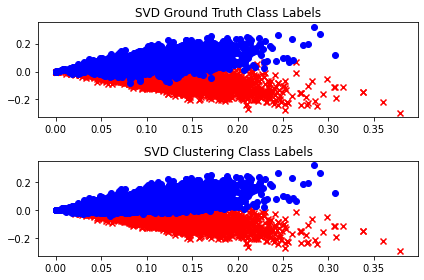

In [ ]:
# Plot the true labels
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

plt.rcParams["figure.autolayout"] = True
plt.subplot(2, 1, 1) # row 1, col 2 index 1
plt.scatter(x[y_target == 0, 0], x[y_target == 0, 1], c='red', marker='x')
plt.scatter(x[y_target == 1, 0], x[y_target == 1, 1], c='blue', marker='o')
plt.title("SVD Ground Truth Class Labels")


plt.subplot(2, 1, 2) # index 2
plt.scatter(x[y_pred == 0, 0], x[y_pred == 0, 1], c='red', marker='x')
plt.scatter(x[y_pred == 1, 0], x[y_pred == 1, 1], c='blue', marker='o')
plt.title("SVD Clustering Class Labels")

plt.show()

In [ ]:
# when r = 3, NMF performs the best
r_best_nmf = 3
best_nmf = NMF(n_components=r_best_nmf, init='random', random_state=42)
x_best_nmf = best_nmf.fit_transform(X_train_tfidf)
reduced_data_df_nmf = pd.DataFrame(x_best_nmf, columns=['Component 1', 'Component 2', 'Component3'])

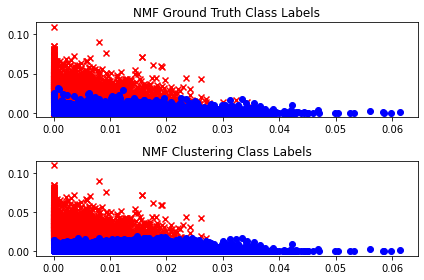

In [ ]:
# fig, ax = plt.subplots(figsize=(12, 10))
# ax.scatter(x_best_nmf[y_target == 0, 0], x_best_nmf[y_target == 0, 1], c='red', marker='x')
# ax.scatter(x_best_nmf[y_target == 1, 0], x_best_nmf[y_target == 1, 1], c='blue', marker='o')

# # Plot the predicted labels
# ax.scatter(x_best_nmf[y_pred == 0, 0], x_best_nmf[y_pred == 0, 1], c='red', marker='x', alpha=0.2)
# ax.scatter(x_best_nmf[y_pred == 1, 0], x_best_nmf[y_pred == 1, 1], c='blue', marker='o', alpha=0.2)

# centers = kmeans.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

plt.rcParams["figure.autolayout"] = True
plt.subplot(2, 1, 1) # row 1, col 2 index 1
plt.scatter(x_best_nmf[y_target == 0, 0], x_best_nmf[y_target == 0, 1], c='red', marker='x')
plt.scatter(x_best_nmf[y_target == 1, 0], x_best_nmf[y_target == 1, 1], c='blue', marker='o')
plt.title("NMF Ground Truth Class Labels")


plt.subplot(2, 1, 2) # index 2
plt.scatter(x_best_nmf[y_pred == 0, 0], x_best_nmf[y_pred == 0, 1], c='red', marker='x')
plt.scatter(x_best_nmf[y_pred == 1, 0], x_best_nmf[y_pred == 1, 1], c='blue', marker='o')
plt.title("NMF Clustering Class Labels")

plt.show()

## Question 9

Obsercations: For the ground truth class label, the data points tends to be more centralized, whereas predicted labels tend to be scattered around more. In terms of claasification, two classes from either true or predicted are almost evenly distributed? Overally not so ideal for K-Means clustering.

## Question 10

In [ ]:
newsgroups_train_all = fetch_20newsgroups(subset='all', shuffle = True, random_state = 42, remove = ('headers', 'footers'))
X_train_tfidf_all = tfidf_vect.fit_transform(newsgroups_train_all.data)

In [ ]:
np.min(newsgroups_train_all.target)

0

In [ ]:
np.max(newsgroups_train_all.target)

19

In [ ]:
y_target_all = []
for i in newsgroups_train_all.target:
  y_target_all.append(i)
y_target_all = np.array(y_target_all)

In [ ]:
svd = TruncatedSVD(n_components=1000, n_iter=7, random_state=42)
x_svd_50 = svd.fit_transform(X_train_tfidf_all)

In [ ]:
kmeans = KMeans(
    n_clusters=20,
    random_state=0,
    max_iter=1500,
    n_init=30,
)
y_pred_all = kmeans.fit_predict(x_svd_50)
con_matrix = contingency_matrix(y_target_all, y_pred_all)

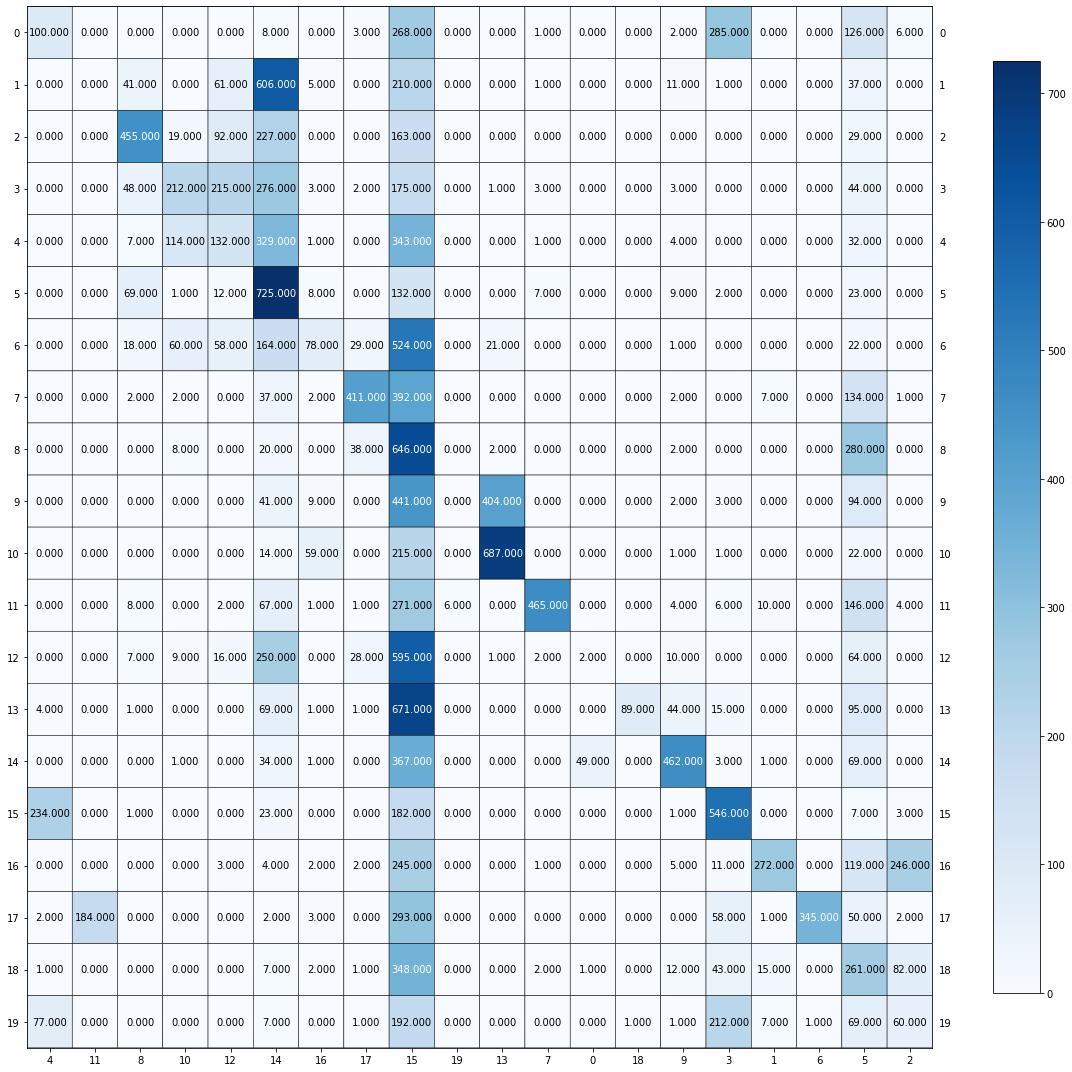

In [ ]:
import numpy as np
from plotmat import plot_mat # using the provided plotmat.py 
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

def match_contingency(y_target, y_pred):
    cm = confusion_matrix(y_target, y_pred)
    rows, cols = linear_sum_assignment(cm, maximize=True)
    plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))


match_contingency(y_target_all, y_pred_all)

In [ ]:
best_nmf_all = NMF(n_components=20, init='random', random_state=42)
x_best_nmf_all = best_nmf_all.fit_transform(X_train_tfidf_all)
kmeans = KMeans(
    n_clusters=20,
    random_state=0,
    max_iter=1500,
    n_init=30,
)
y_pred_nmf_all = kmeans.fit_predict(x_best_nmf_all)
con_matrix_nmf_all = contingency_matrix(y_target_all, y_pred_nmf_all)

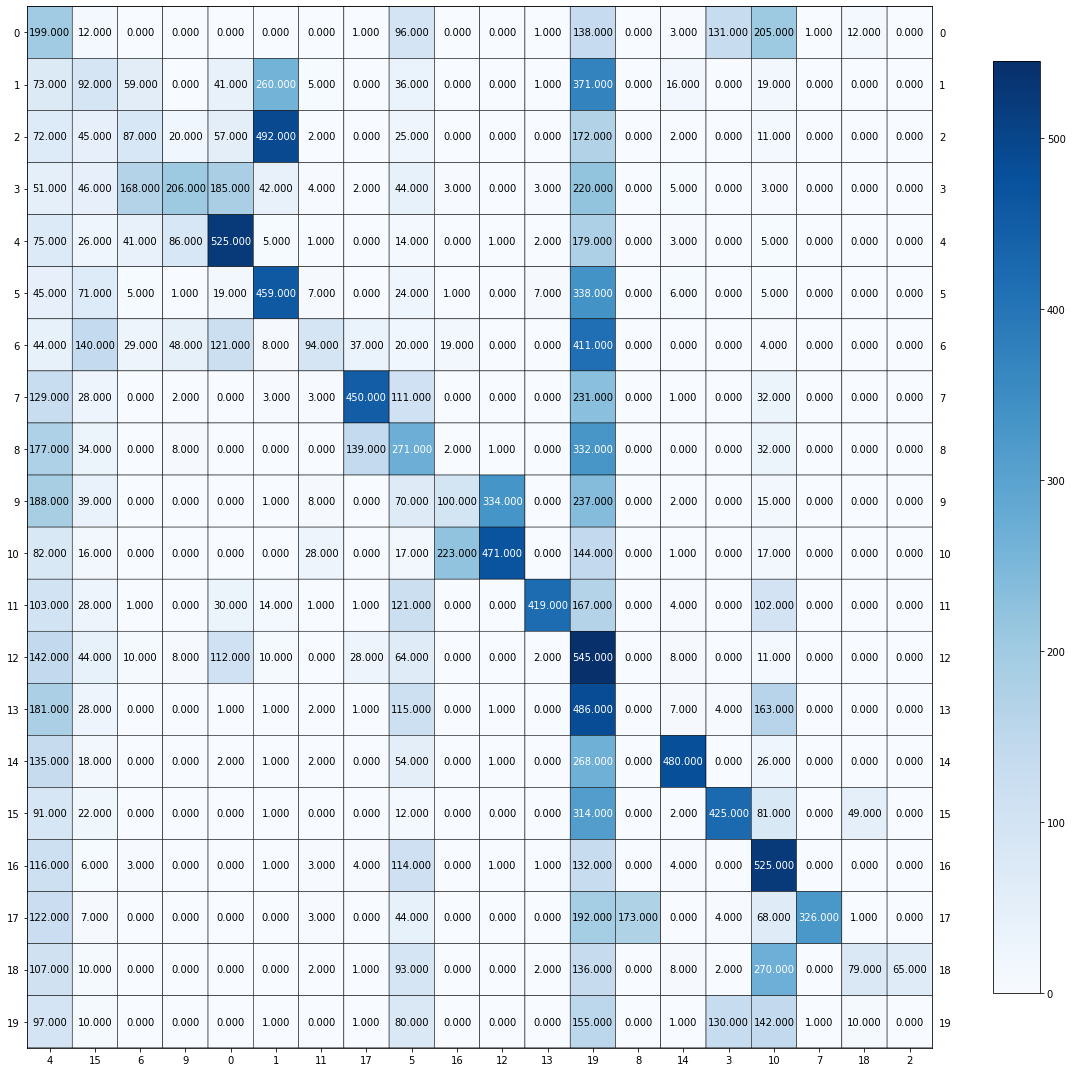

[ 4 15  6  9  0  1 11 17  5 16 12 13 19  8 14  3 10  7 18  2]


In [ ]:
cm_nmf_all = confusion_matrix(y_target_all, y_pred_nmf_all)
rows, cols = linear_sum_assignment(cm_nmf_all, maximize=True)
plot_mat(cm_nmf_all[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))
print(cols)

plot

In [ ]:
print("Homogeneity score: ", metrics.homogeneity_score(y_target_all,y_pred_all))

Homogeneity score:  0.33232192196996857


## Question 11

In [ ]:
!pip3 install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=c43d60044127fb0b5ee009d5342915489074371a749c41ab15898464fb66c06d
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=f494f43d5f688a03a3c8e2d45eac92537d8ce79a8faf32cf847ae1ae0581714a
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent


In [ ]:
import umap

In [ ]:

def umap_fit_predict(n, m):
    reducer = umap.UMAP(n_components = n, metric = m)
    x_train_umap = reducer.fit_transform(X_train_tfidf_all)

    y_pred_all = kmeans.fit_predict(x_train_umap)
    print(f"******************************** This is for components = {n} and metric = {m} **************************************")
    # contingency matrix
    match_contingency(y_target_all, y_pred_all)

    # print out five metrics
    print("Homogeneity score: ", metrics.homogeneity_score(y_target_all, y_pred_all))
    print("Completeness score: ",metrics.completeness_score(y_target_all, y_pred_all))
    print("V-measure score: ",metrics.v_measure_score(y_target_all, y_pred_all))
    print("Adjusted Rand score: ",metrics.adjusted_rand_score(y_target_all, y_pred_all))
    print("Adjusted mutual information score: ",metrics.adjusted_mutual_info_score(y_target_all, y_pred_all))
    

******************************** This is for components = 5 and metric = cosine **************************************


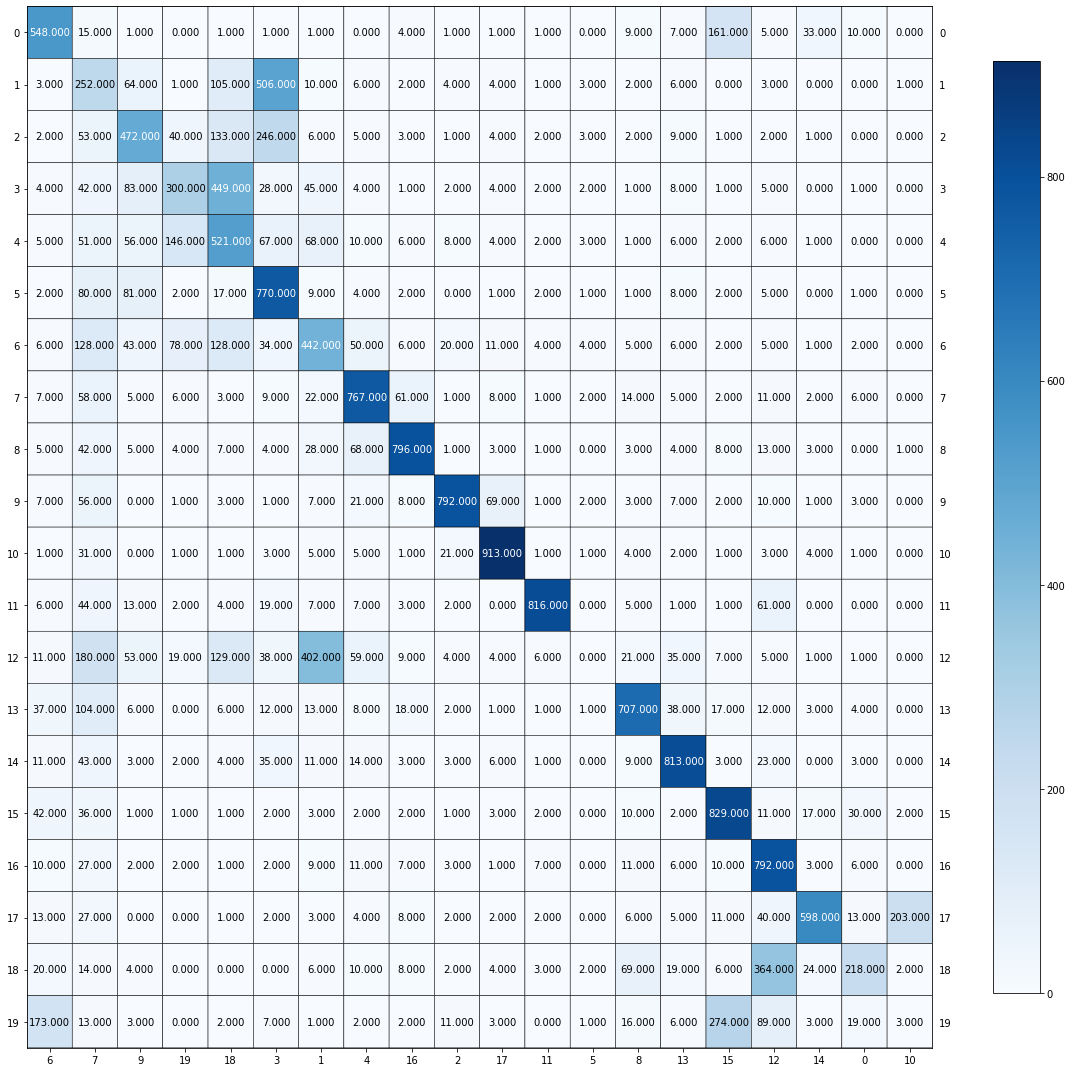

Homogeneity score:  0.5650339961671332
Completeness score:  0.5886248184418985
V-measure score:  0.5765882064882293
Adjusted Rand score:  0.4384477287438883
Adjusted mutual information score:  0.5751803773215675
******************************** This is for components = 5 and metric = euclidean **************************************


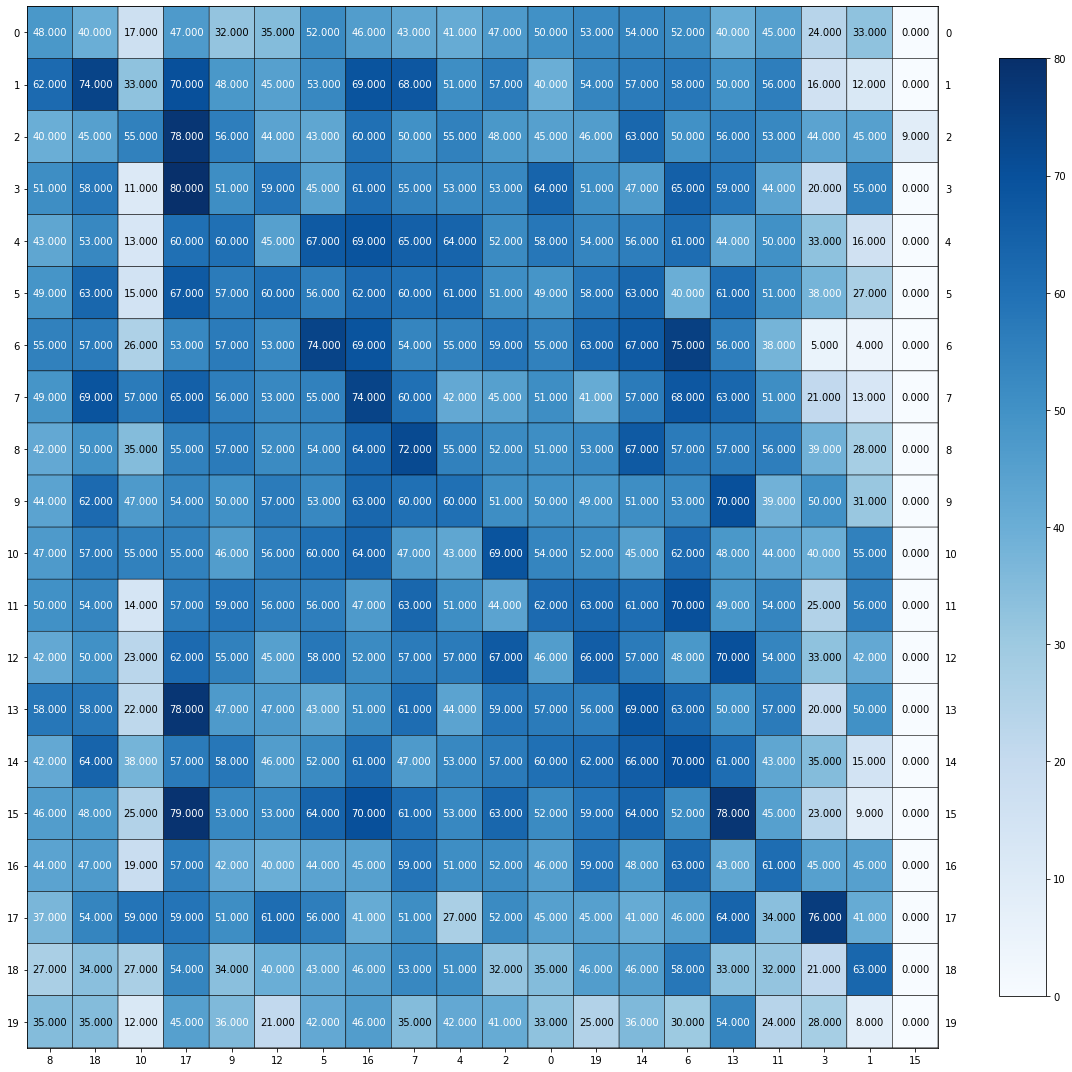

Homogeneity score:  0.008126923303624774
Completeness score:  0.008293339729847181
V-measure score:  0.008209288216392366
Adjusted Rand score:  0.0009703264502103557
Adjusted mutual information score:  0.004978029082859678
******************************** This is for components = 20 and metric = cosine **************************************


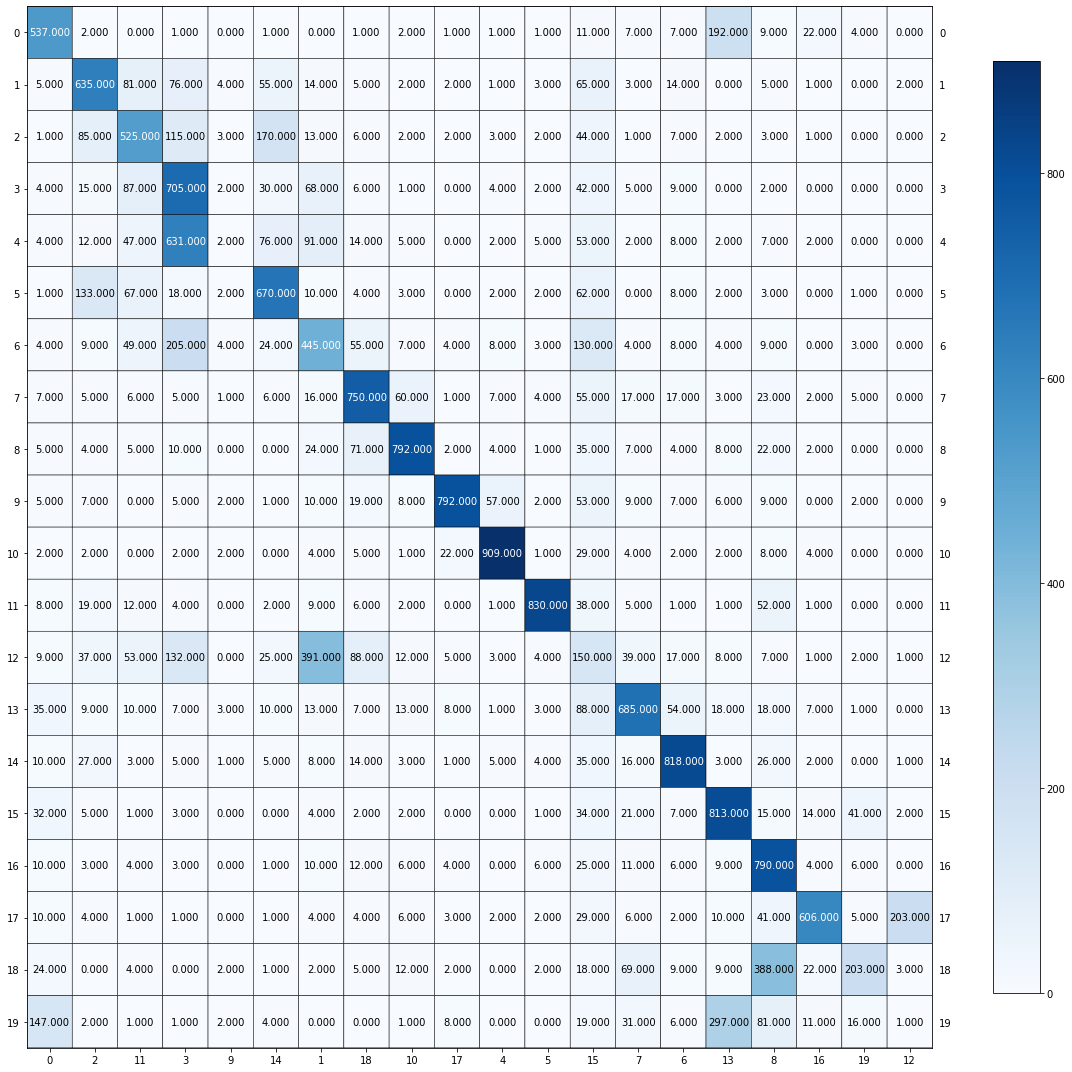

Homogeneity score:  0.5714229935741647
Completeness score:  0.5941648624644738
V-measure score:  0.5825720688956398
Adjusted Rand score:  0.4542450346054344
Adjusted mutual information score:  0.5811856917654461
******************************** This is for components = 20 and metric = euclidean **************************************


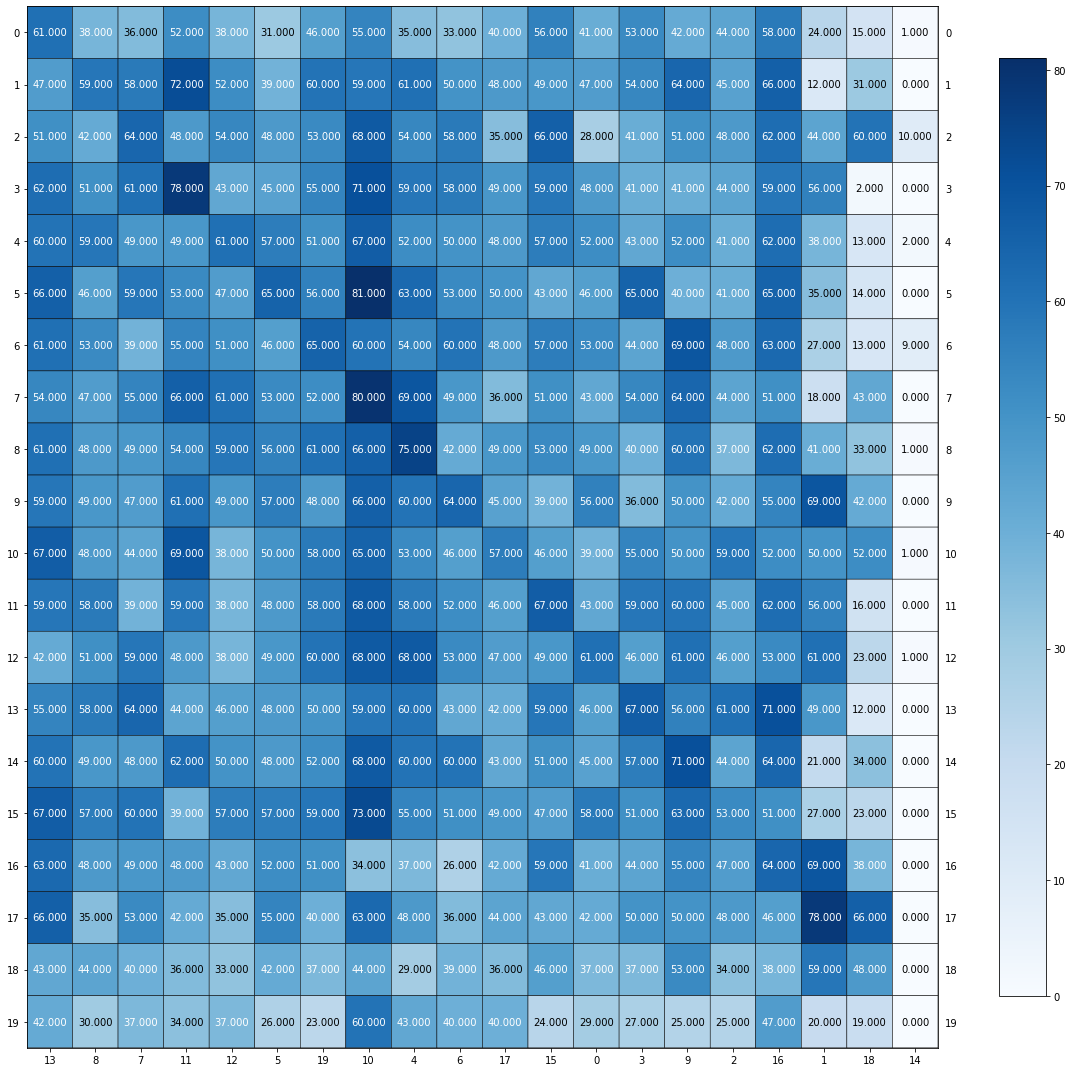

Homogeneity score:  0.0075152197421469915
Completeness score:  0.00764254889038856
V-measure score:  0.007578349517499403
Adjusted Rand score:  0.0009018777022203397
Adjusted mutual information score:  0.004321263065443307
******************************** This is for components = 200 and metric = cosine **************************************


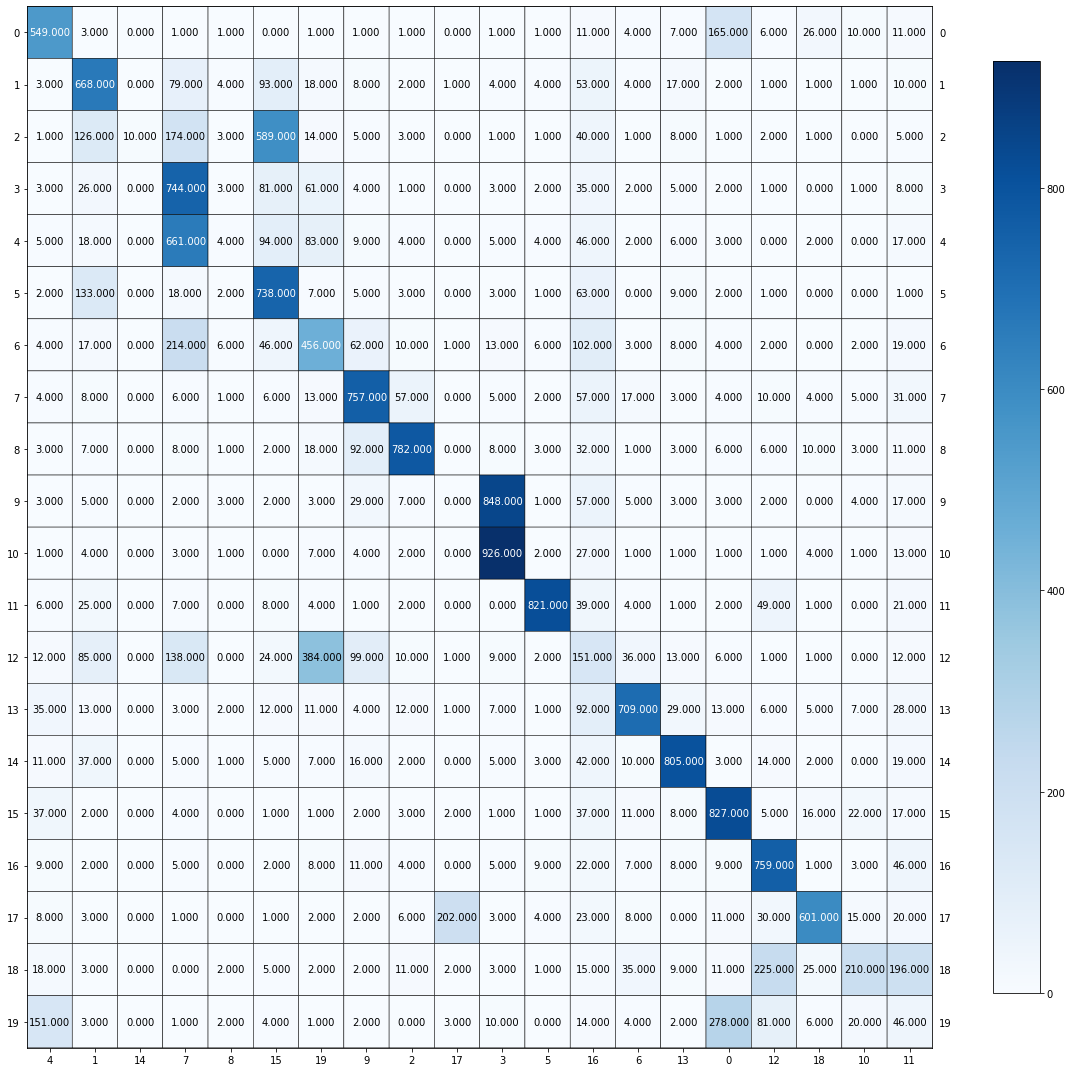

Homogeneity score:  0.5584223966386449
Completeness score:  0.597577922099022
V-measure score:  0.5773370301511216
Adjusted Rand score:  0.4384958756535239
Adjusted mutual information score:  0.5759124379591841
******************************** This is for components = 200 and metric = euclidean **************************************


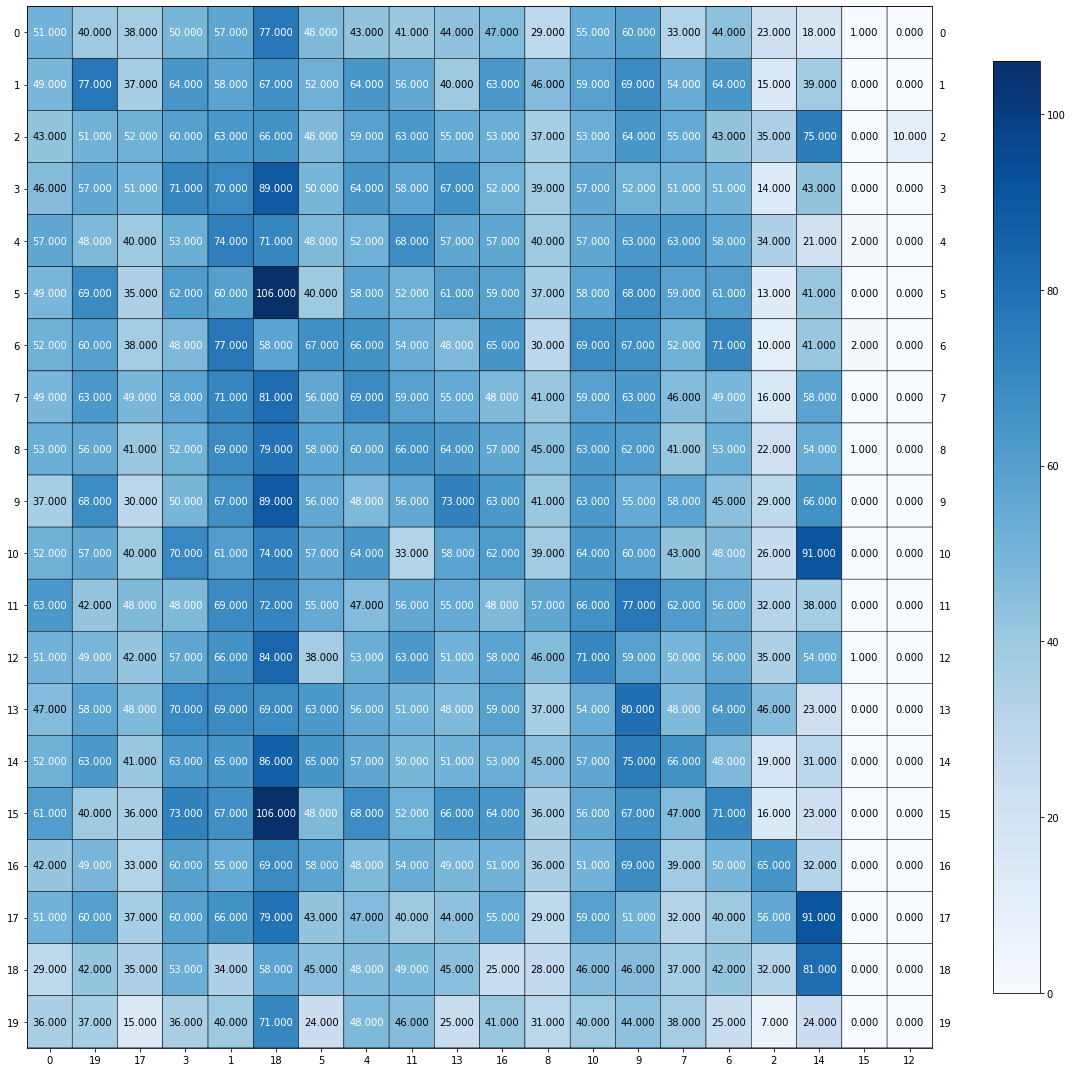

Homogeneity score:  0.006991100388349019
Completeness score:  0.00727200067503276
V-measure score:  0.007128784479248705
Adjusted Rand score:  0.0008973570253049367
Adjusted mutual information score:  0.00387344040636333


In [ ]:
components_selection = [5, 20, 200]
metric_selection = ['cosine', 'euclidean']
for n in components_selection:
    for m in metric_selection:
        umap_fit_predict(n, m)

## Question 12

Based on the matrix and the evaluation metrics, we can see that when n_components = 5, it has a higher average performance score than the other. In terms of the metric choice, 'cosine' generally works much better than 'euclidean'.

## Question 13

In [ ]:

def model_fit_predict(model, n):
    if model == 'non':
        x_train_model = X_train_tfidf_all
    elif model == 'svd':
        reducer = TruncatedSVD(n_components = n , n_iter=7, random_state=42)
        x_train_model = reducer.fit_transform(X_train_tfidf_all)
    elif model == 'nmf':
        reducer = NMF(n_components= n, init='random', max_iter = 8000)
        x_train_model = reducer.fit_transform(X_train_tfidf_all)
    elif model == 'umap':
        reducer = umap.UMAP(n_components = n, metric = 'cosine')
        x_train_model = reducer.fit_transform(X_train_tfidf_all)

    y_pred_all = kmeans.fit_predict(x_train_model)
    # print out five metrics
    print('* '*20 + 'model = ' + model + ' *'*20)
    print("Homogeneity score: ", metrics.homogeneity_score(y_target_all, y_pred_all))
    print("Completeness score: ",metrics.completeness_score(y_target_all, y_pred_all))
    print("V-measure score: ",metrics.v_measure_score(y_target_all, y_pred_all))
    print("Adjusted Rand score: ",metrics.adjusted_rand_score(y_target_all, y_pred_all))
    print("Adjusted mutual information score: ",metrics.adjusted_mutual_info_score(y_target_all, y_pred_all))

In [ ]:
model_fit_predict('non', 5)
model_fit_predict('svd', 5)
model_fit_predict('nmf', 5)
model_fit_predict('umap', 5)

* * * * * * * * * * * * * * * * * * * * model = non * * * * * * * * * * * * * * * * * * * *
Homogeneity score:  0.34822613229253674
Completeness score:  0.3972583550944453
V-measure score:  0.3711297628749277
Adjusted Rand score:  0.12222040634062074
Adjusted mutual information score:  0.36895540765578677
* * * * * * * * * * * * * * * * * * * * model = svd * * * * * * * * * * * * * * * * * * * *
Homogeneity score:  0.32313809864466086
Completeness score:  0.35118683066780604
V-measure score:  0.3365791172713842
Adjusted Rand score:  0.12666159829052642
Adjusted mutual information score:  0.3343406151857584
* * * * * * * * * * * * * * * * * * * * model = nmf * * * * * * * * * * * * * * * * * * * *
Homogeneity score:  0.2910825688359765
Completeness score:  0.322816426702058
V-measure score:  0.30612929954228607
Adjusted Rand score:  0.10033439938582789
Adjusted mutual information score:  0.303763784809196
* * * * * * * * * * * * * * * * * * * * model = umap * * * * * * * * * * * * * * *

Based on the above metrics, we can clearly see that when we choose umap and metric = 'cosine' to do the dimemsion reduction, we are getting much better performance than the other. 

## Question 14

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
reducer = umap.UMAP(n_components = 5, metric = 'cosine')
x_train_agg = reducer.fit_transform(X_train_tfidf_all)

agg_ward = AgglomerativeClustering(n_clusters=20, linkage='ward')
agg_ward.fit(x_train_agg)

y_pred_agg = agg_ward.fit_predict(x_train_agg)

print('* '*20 + "Agglomerative clustering with ward " + ' *'*20)
print("Homogeneity score: ", metrics.homogeneity_score(y_target_all, y_pred_agg))
print("Completeness score: ",metrics.completeness_score(y_target_all, y_pred_agg))
print("V-measure score: ",metrics.v_measure_score(y_target_all, y_pred_agg))
print("Adjusted Rand score: ",metrics.adjusted_rand_score(y_target_all, y_pred_agg))
print("Adjusted mutual information score: ",metrics.adjusted_mutual_info_score(y_target_all, y_pred_agg))

* * * * * * * * * * * * * * * * * * * * Agglomerative clustering with ward  * * * * * * * * * * * * * * * * * * * *
Homogeneity score:  0.5482525053767325
Completeness score:  0.5877279289105357
V-measure score:  0.5673043298624193
Adjusted Rand score:  0.4197440070869362
Adjusted mutual information score:  0.5658442674657356


In [ ]:
agg_single = AgglomerativeClustering(n_clusters=20, linkage='single')
agg_single.fit(x_train_agg)

y_pred_aggs = agg_single.fit_predict(x_train_agg)

print('* '*20  + "Agglomerative clustering with single " + ' *'*20)
print("Homogeneity score: ", metrics.homogeneity_score(y_target_all, y_pred_aggs))
print("Completeness score: ",metrics.completeness_score(y_target_all, y_pred_aggs))
print("V-measure score: ",metrics.v_measure_score(y_target_all, y_pred_aggs))
print("Adjusted Rand score: ",metrics.adjusted_rand_score(y_target_all, y_pred_aggs))
print("Adjusted mutual information score: ",metrics.adjusted_mutual_info_score(y_target_all, y_pred_aggs))

* * * * * * * * * * * * * * * * * * * * Agglomerative clustering with single  * * * * * * * * * * * * * * * * * * * *
Homogeneity score:  0.016448568668440695
Completeness score:  0.38299968932399814
V-measure score:  0.031542491743481255
Adjusted Rand score:  0.0004922978020463246
Adjusted mutual information score:  0.026829904835511783


## Question 15

In [ ]:
!pip3 install hdbscan
import hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 52.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp38-cp38-linux_x86_64.whl size=3773986 sha256=dcc663dd42baa343b37ad6f64b50adb895f72360bba1a8a377a5f04496ee8abc
  Stored in directory: /root/.cache/pip/wheels/76/06/48/527e038689c581cc9e519c73840efdc7473805149e55bd7ffd
Successfully built hdbscan


In [ ]:

def hdbscan_fit_predict(n, con = False, metric = True):
    reducer = umap.UMAP(n_components = 5, metric = 'cosine')
    x_train_umap = reducer.fit_transform(X_train_tfidf_all)

    clusterer = hdbscan.HDBSCAN(min_cluster_size = n)
    clusterer.fit(x_train_umap)

    y_pred_hbs = clusterer.fit_predict(x_train_umap)
    print(np.max(y_target_all))
    print(np.max(y_pred_hbs))
    if con == True:
        match_contingency(y_target_all, y_pred_hbs)
        
    if metric == True:
    # print out five metrics
        print('* '*20  + f"HDBSCAN clustering using n = {n}" + ' *'*20)
        print("Homogeneity score: ", metrics.homogeneity_score(y_target_all, y_pred_hbs))
        print("Completeness score: ",metrics.completeness_score(y_target_all, y_pred_hbs))
        print("V-measure score: ",metrics.v_measure_score(y_target_all, y_pred_hbs))
        print("Adjusted Rand score: ",metrics.adjusted_rand_score(y_target_all, y_pred_hbs))
        print("Adjusted mutual information score: ",metrics.adjusted_mutual_info_score(y_target_all, y_pred_hbs))

In [ ]:
for i in [20, 100, 200]:
    hdbscan_fit_predict(i)

* * * * * * * * * * * * * * * * * * * * HDBSCAN clustering using n = 20 * * * * * * * * * * * * * * * * * * * *
Homogeneity score:  0.4230611882816941
Completeness score:  0.44592964943977353
V-measure score:  0.4341945143557393
Adjusted Rand score:  0.0765125221366856
Adjusted mutual information score:  0.42191619468306446
* * * * * * * * * * * * * * * * * * * * HDBSCAN clustering using n = 100 * * * * * * * * * * * * * * * * * * * *
Homogeneity score:  0.4195598422965518
Completeness score:  0.6117266579455519
V-measure score:  0.49773935773614836
Adjusted Rand score:  0.2055955421253045
Adjusted mutual information score:  0.4966244558457247
* * * * * * * * * * * * * * * * * * * * HDBSCAN clustering using n = 200 * * * * * * * * * * * * * * * * * * * *
Homogeneity score:  0.4127112387829237
Completeness score:  0.6113434401944065
V-measure score:  0.4927633527858392
Adjusted Rand score:  0.20846825639694092
Adjusted mutual information score:  0.491734924282406


## Question 16

In this case, we are given 10 clusters. Though I haven't seem cluster with label '-1', it refers to that the data does not belong to any clusters. **Still need to to interpret contingency matrix, who knows what they want us to say**

19
8


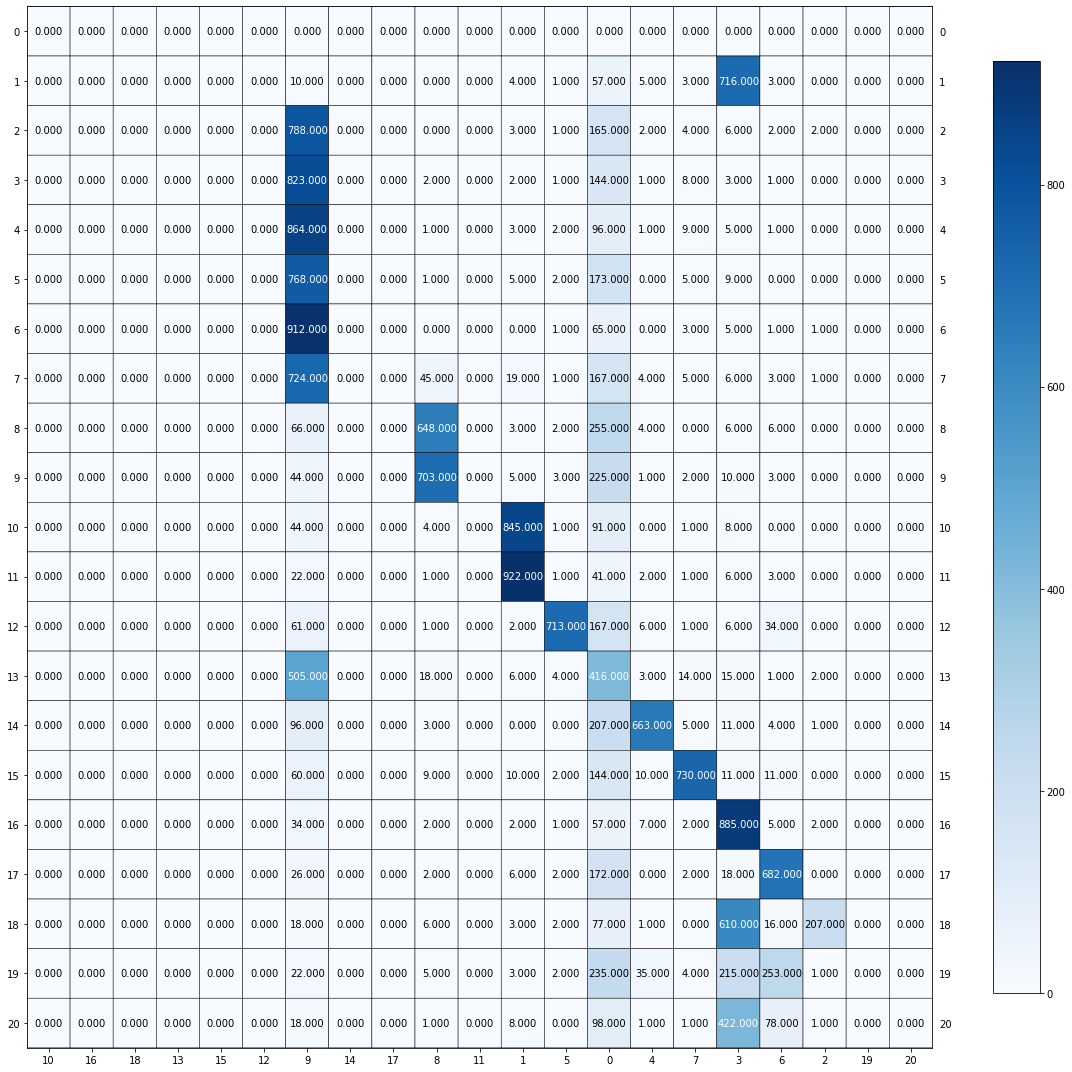

In [ ]:
# Based on the observation: we can see that the n = 100 is better
hdbscan_fit_predict(100, con = True, metric = False)

## Question 17

Based on our experiments, UMAP with n_components = 5 and metric = 'cosine' and Kmeans(20) have the best performance score, reaching v-measures about 0.582. **Need to tell more about why - leave to tomorrow**

## Question 18 - Extra Credit

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
# normalize the input vectors
scaler = StandardScaler(with_mean=False)
normalized_X_train_tfidf = scaler.fit_transform(X_train_tfidf_all)

# dimensionality reduction
reducer = umap.UMAP(n_components = 20, metric = 'cosine')
normalized_x_train_agg = reducer.fit_transform(normalized_X_train_tfidf)

In [ ]:
k_means = KMeans(n_clusters = 20)
k_means.fit(normalized_x_train_agg)
y_pred_normalized = k_means.fit_predict(normalized_x_train_agg)

print('* '*20 + "KMeans clustering with Scalar " + ' *'*20)
print("Homogeneity score: ", metrics.homogeneity_score(y_target_all, y_pred_normalized))
print("Completeness score: ",metrics.completeness_score(y_target_all, y_pred_normalized))
print("V-measure score: ",metrics.v_measure_score(y_target_all, y_pred_normalized))
print("Adjusted Rand score: ",metrics.adjusted_rand_score(y_target_all, y_pred_normalized))
print("Adjusted mutual information score: ",metrics.adjusted_mutual_info_score(y_target_all, y_pred_normalized))

In [ ]:
hdb = hdbscan.HDBSCAN(min_cluster_size = 300)
hdb.fit(normalized_x_train_agg)
y_pred_normalized_hdb = hdb.fit_predict(normalized_x_train_agg)

print('* '*20 + "KMeans clustering with Scalar " + ' *'*20)
print("Homogeneity score: ", metrics.homogeneity_score(y_target_all, y_pred_normalized_hdb))
print("Completeness score: ",metrics.completeness_score(y_target_all, y_pred_normalized_hdb))
print("V-measure score: ",metrics.v_measure_score(y_target_all, y_pred_normalized_hdb))
print("Adjusted Rand score: ",metrics.adjusted_rand_score(y_target_all, y_pred_normalized_hdb))
print("Adjusted mutual information score: ",metrics.adjusted_mutual_info_score(y_target_all, y_pred_normalized_hdb))

In [ ]:
agg = AgglomerativeClustering(n_clusters = 20)
agg.fit(normalized_x_train_agg)
y_pred_normalized_agg = agg.fit_predict(normalized_x_train_agg)

print('* '*20 + "KMeans clustering with Scalar " + ' *'*20)
print("Homogeneity score: ", metrics.homogeneity_score(y_target_all, y_pred_normalized_agg))
print("Completeness score: ",metrics.completeness_score(y_target_all, y_pred_normalized_agg))
print("V-measure score: ",metrics.v_measure_score(y_target_all, y_pred_normalized_agg))
print("Adjusted Rand score: ",metrics.adjusted_rand_score(y_target_all, y_pred_normalized_agg))
print("Adjusted mutual information score: ",metrics.adjusted_mutual_info_score(y_target_all, y_pred_normalized_agg))

In [ ]:
# from sklearn.ensemble import BaggingClassifier

# bagging = BaggingClassifier(base_estimator = kmeans, n_estimators=10, random_state=0)
# x_train_umap= x_train_agg

# bagging.fit(x_train_umap, y_target_all)
# y_pred_bag = bagging.predict(x_train_umap)

# print('* '*20  + "BaggingClassifier" + ' *'*20)
# print("Homogeneity score: ", metrics.homogeneity_score(y_target_all, y_pred_bag))
# print("Completeness score: ",metrics.completeness_score(y_target_all, y_pred_bag))
# print("V-measure score: ",metrics.v_measure_score(y_target_all, y_pred_bag))
# print("Adjusted Rand score: ",metrics.adjusted_rand_score(y_target_all, y_pred_bag))
# print("Adjusted mutual information score: ",metrics.adjusted_mutual_info_score(y_target_all, y_pred_bag))

* * * * * * * * * * * * * * * * * * * * BaggingClassifier * * * * * * * * * * * * * * * * * * * *
Homogeneity score:  0.42275785933316506
Completeness score:  0.5083540735120875
V-measure score:  0.4616215780728951
Adjusted Rand score:  0.28862536098432795
Adjusted mutual information score:  0.45979343475017903
